In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [6]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
#stoi = sorted(stoi)
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(f'{vocab_size=}')

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
vocab_size=27


In [9]:
block_size = 3

def build_dataset(words):
    X, Y = [], []
    
    for w in words:
        context = [0]*block_size
        for ch in w+'.':
            X.append(context)
            ix = stoi[ch]
            Y.append(ix)
            context = context[1:]+[ix]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
print(n1, n2)

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

25626 28829
torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


In [45]:
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn([vocab_size, n_embd], generator=g)
W1 = torch.randn((block_size*n_embd, n_hidden), generator=g)
b1 = torch.randn(n_hidden, generator=g)
W2 = torch.randn((n_hidden, vocab_size), generator=g)*0.01
b2 = torch.randn(vocab_size, generator=g)*0
parameters = [C, W1, b1, W2, b2]
for p in parameters:
  p.requires_grad = True

In [46]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
    
    emb = C[Xb]
    embcat = emb.view(Xb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)


    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.3148
  10000/ 200000: 2.6505
  20000/ 200000: 2.4705
  30000/ 200000: 2.0266
  40000/ 200000: 2.1797
  50000/ 200000: 2.4072
  60000/ 200000: 2.2316
  70000/ 200000: 2.0701
  80000/ 200000: 2.0010
  90000/ 200000: 2.0439
 100000/ 200000: 2.4564
 110000/ 200000: 2.2124
 120000/ 200000: 2.1843
 130000/ 200000: 2.2414
 140000/ 200000: 2.1447
 150000/ 200000: 2.2837
 160000/ 200000: 2.0286
 170000/ 200000: 2.0146
 180000/ 200000: 2.2178
 190000/ 200000: 2.0372


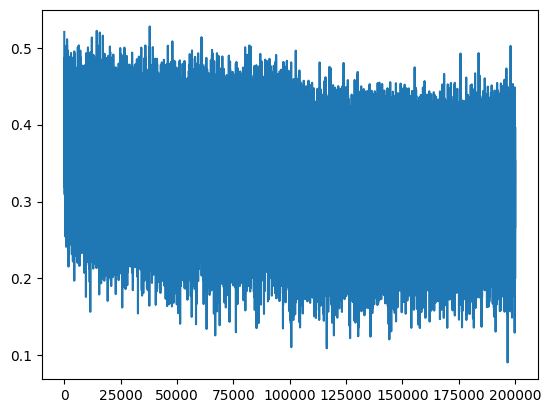

In [55]:
plt.plot(lossi)

In [56]:
@torch.no_grad()
def split_loss(split):
    x, y ={
        'train' : (Xtr, Ytr),
        'val' : (Xdev, Ydev),
        'test' : (Xte, Yte)
    }[split]
    emb = C[x]
    embcat = emb.view(x.shape[0], -1)
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')
    

train 2.0693247318267822
val 2.1332099437713623


In [57]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

mora.
mayanniee.
mel.
rylia.
emmadieja.
leg.
azee.
daelin.
shi.
jenne.
elisson.
arleigh.
malara.
noshubergahimier.
kin.
renelipanthona.
unzey.
daryamyleyeks.
kayshia.
kyla.


In [25]:
lg = torch.randn(2,2)
print(lg)
torch.softmax(lg, dim=0)

tensor([[-0.7692, -1.4719],
        [-1.6719,  1.3598]])


tensor([[0.7115, 0.0556],
        [0.2885, 0.9444]])